In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
import re
from scipy import interpolate
# 図のスタイル設定
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 5)

print("ライブラリ読み込み完了")
import japanize_matplotlib


ライブラリ読み込み完了


In [2]:
def make_time_row(df):
    df["time"] = np.arange(0, len(df)) / 100
    return df
def get_first_trigger_segment(df, trigger_col="value", trigger_value=2):
    """
    最初のトリガー値(trigger_value)が立ってから
    次のトリガーが立つ直前までの区間を返す。
    """

    trigger_idx = df.index[df[trigger_col] >= trigger_value].tolist()
    print(trigger_idx)


    if len(trigger_idx) == 0:
        return None  # トリガーが無い

    # 最初のトリガー開始
    start = trigger_idx[0]

    # 次のトリガーがあるか？
    # if len(trigger_idx) >= 2:
        # end = trigger_idx[-1]
    # else:
    end = df.index[-1]  # トリガーが1回だけの場合、最後まで
    
    print(start,end)

    return df.loc[start:end].reset_index(drop=True)

def fix_columns(df):
    cleaned = [re.sub(r'\.\d+$', '', c) for c in df.columns]  # .1 や .2 を除去
    new_cols = []
    seen = {}

    for col in cleaned:
        if col not in seen:
            seen[col] = 1
            new_cols.append(f"{col}_1")
        else:
            seen[col] += 1
            new_cols.append(f"{col}_{seen[col]}")

    df.columns = new_cols
    return df

def estimate_sampling_rate(df):
    t = df['time'].values
    # 時刻差分（dt）を計算
    dt = np.diff(t)
    # 正の値のみ（たまに逆順やゼロが混ざるため）
    dt = dt[dt > 0]
    # メジアンをサンプリング周期とする
    dt_med = np.median(dt)
    # sampling rate [Hz]
    fs = 1.0 / dt_med
    return fs, dt_med


In [3]:
data_info = pd.read_excel(r"C:\Users\youli\Desktop\code\20251118_COPモドキ\info.xlsx")
data_info

,sub,subject_id,seat,cop,pedal,steer,label
0,A,1,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,2F
1,B,2,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,2F
2,C,3,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,2F
3,D,4,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,2F
4,E,5,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,2F
5,F,6,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,2F
6,G,7,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,2F
7,A,1,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,3F
8,C,3,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,3F
9,E,5,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,3F


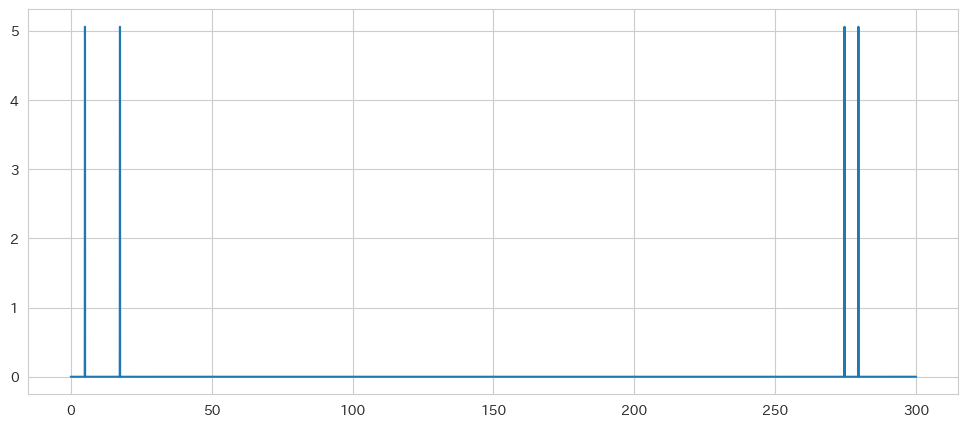

[499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 1741, 1742, 1743, 1744, 1745, 1746, 1747, 1748, 1749, 1750, 27449, 27450, 27451, 27452, 27453, 27454, 27455, 27456, 27457, 27458, 27943, 27944, 27945, 27946, 27947, 27948, 27949, 27950, 27951, 27952]
499 29999
Sampling rate: 41.66666666666509 Hz


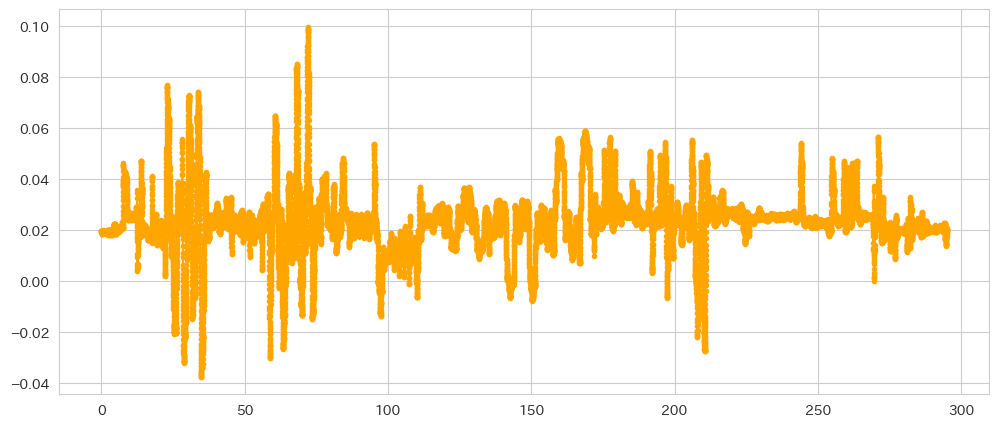

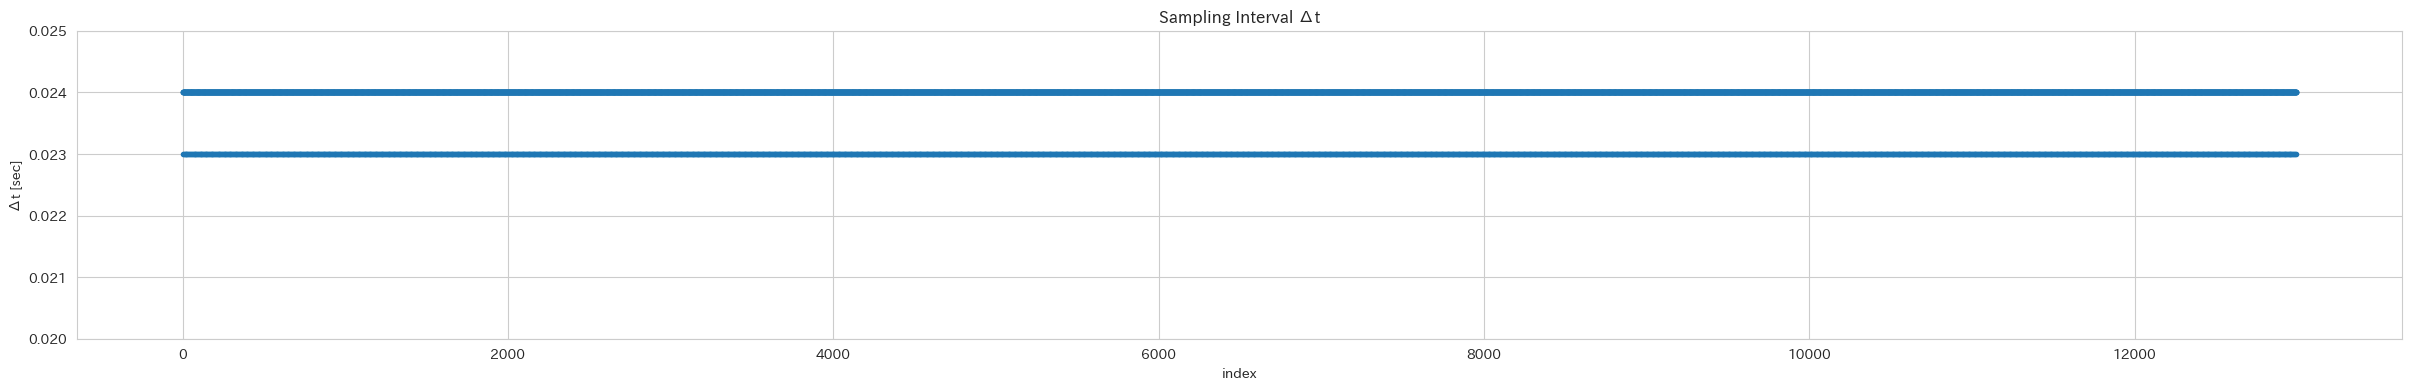

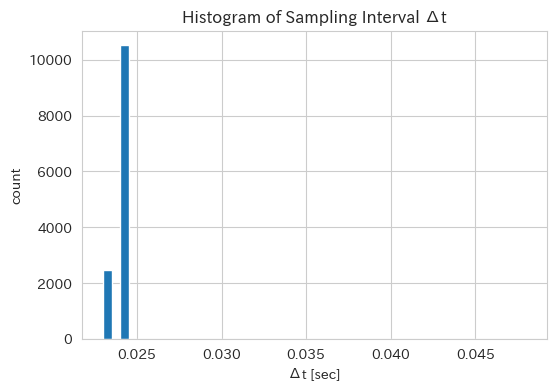

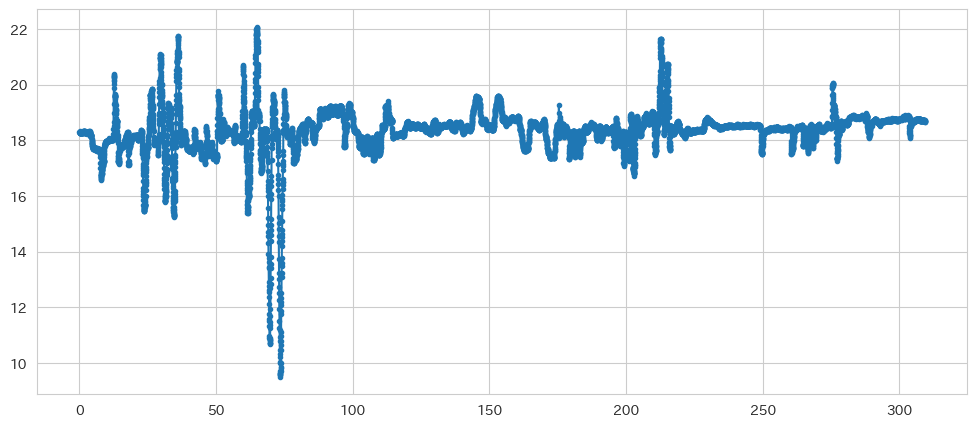

In [4]:
for num, idx in enumerate(data_info.index): 
    row = data_info.iloc[idx,:] 
    sub_ = row['sub'] 
    seat_path = row['seat']
    cop_path = row['cop']
    pedal_path = row['pedal']
    steer_path = row['steer']
    label = row['label']
    subject_id_ = row['subject_id']

    if (label == "3F") or (subject_id_ != 7): # 3
        continue

    df_seat = pd.read_csv(seat_path,skiprows=1)
    df_cop = pd.read_csv(cop_path,skiprows=21)
    df_pedal = pd.read_csv(pedal_path,skiprows=21)
    df_steer = pd.read_csv(steer_path,skiprows=21)

    
    df_pedal.rename(columns={'Untitled 4':'pedal'},inplace=True)
    df_steer.rename(columns={'Untitled 1':'steer','Untitled 2':'trg'},inplace=True)
    df_cop.rename(columns={'Untitled 2':'COP_X','Untitled 3':'COP_Y'},inplace=True)
    df_pedal = make_time_row(df_pedal)
    df_steer = make_time_row(df_steer)
    df_cop = make_time_row(df_cop)
    
    df_mock = pd.merge(df_cop[['time','COP_X','COP_Y']], df_steer[['time','steer','trg']], on='time', how='left', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)') 
    df_mock = pd.merge(df_mock, df_pedal[['time','pedal']], on='time', how='left', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)') 
    
    plt.plot(df_mock.time,df_mock.trg)
    plt.show()


    df_mock_tmp = get_first_trigger_segment(df_mock, trigger_col="trg", trigger_value=1)
    df_mock_tmp['time'] -= df_mock_tmp['time'].iloc[0]
    plt.plot(df_mock_tmp.time,df_mock_tmp['COP_X'],'.-',color='orange')

    df_seat = fix_columns(df_seat)
    df_seat['time'] = df_seat['時間_1']
    fs, dt = estimate_sampling_rate(df_seat)
    print("Sampling rate:", fs, "Hz")

    # time 差分（サンプリング間隔）
    dt = df_seat['time'].diff()

    plt.figure(figsize=(30,4))
    plt.plot(dt,'.')
    plt.title("Sampling Interval Δt")
    plt.xlabel("index")
    plt.ylabel("Δt [sec]")
    plt.ylim(0.020,0.025)
    plt.grid(True)
    plt.show()


    plt.figure(figsize=(6,4))
    plt.hist(dt.dropna(), bins=50)
    plt.title("Histogram of Sampling Interval Δt")
    plt.xlabel("Δt [sec]")
    plt.ylabel("count")
    plt.grid(True)
    plt.show()



    plt.plot(df_seat.time,df_seat['圧力中心列_2'],'.-')

    
    break


# リサンプリング

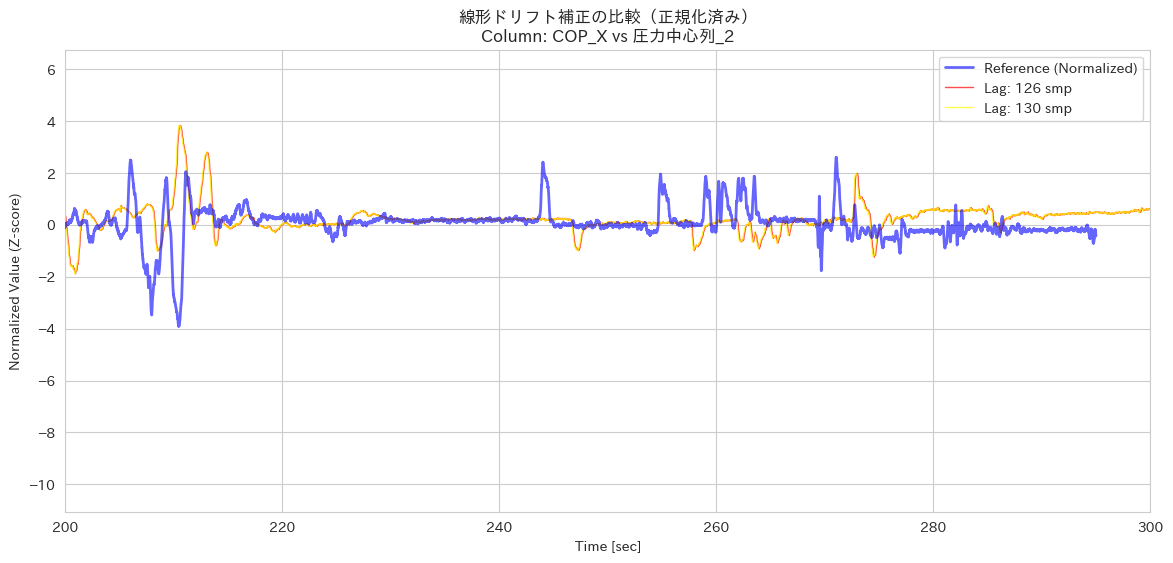

In [5]:
def visualize_linear_drifts_normalized(df_ref, df_target, drift_samples_list, 
                                     col_ref='COP_X', col_target='圧力中心列_2'):
    """
    線形ドリフトの比較（正規化付き）
    縦軸のスケールが異なるデータを、正規化して重ね書きします。
    """
    
    # --- 1. 前処理: 正規化 (Z-score normalization) ---
    # 平均を引いて標準偏差で割ることで、両方の波形を似たようなサイズにします
    ref_data = df_ref[col_ref]
    ref_norm = (ref_data - ref_data.mean()) / ref_data.std()
    
    target_data = df_target[col_target]
    target_norm = (target_data - target_data.mean()) / target_data.std()
    
    # --- 2. 時間軸計算の準備 ---
    dt_mean = df_target['time'].diff().mean()
    t_start = df_target['time'].min()
    t_end_orig = df_target['time'].max()
    duration = t_end_orig - t_start
    
    plt.figure(figsize=(14, 6))
    
    # --- 3. 正解データのプロット（青・太線） ---
    # 正規化した値を使います
    plt.plot(df_ref['time'], ref_norm, color='blue', linewidth=2,alpha = 0.6, label='Reference (Normalized)', zorder=10)
    
    # 色の準備
    colors = plt.cm.autumn(np.linspace(0, 1, len(drift_samples_list)))
    
    # --- 4. 各ドリフト量ごとのシミュレーション ---
    for i, drift_samples in enumerate(drift_samples_list):
        
        # ズレ時間の計算
        total_lag_time = drift_samples * dt_mean
        
        # 伸縮率 (Scale Factor)
        scale_factor = duration / (duration + total_lag_time)
        
        # 時間軸の再計算（線形変換）
        # 時間tに応じて補正量が大きくなる
        new_time = t_start + (df_target['time'] - t_start) * scale_factor
        
        # プロット（正規化した値 target_norm を使用）
        plt.plot(new_time, target_norm, 
                 color=colors[i], 
                 linewidth=1, 
                 alpha=0.7,
                 linestyle='-',
                 label=f'Lag: {drift_samples} smp')

    # --- 5. 見やすさの調整 ---
    plt.title(f"線形ドリフト補正の比較（正規化済み）\nColumn: {col_ref} vs {col_target}")
    plt.xlabel("Time [sec]")
    plt.ylabel("Normalized Value (Z-score)")
    plt.legend(loc='upper right')
    plt.grid(True)
    
    # ★重要: ズレが顕著な「後半部分」を拡大表示（必要に応じてコメントアウトを外してください）
    # plt.xlim(0,100)
    plt.xlim(200,300)
    plt.show()

# ==========================================
# 実行
# ==========================================

# 試したいサンプルズレのリスト
try_drifts = [126,130] 

visualize_linear_drifts_normalized(
    df_mock_tmp, 
    df_seat, 
    try_drifts,
    col_ref='COP_X',         # df_ref (df_mock_tmp) の列名
    col_target='圧力中心列_2' # df_target (df_seat) の列名
)

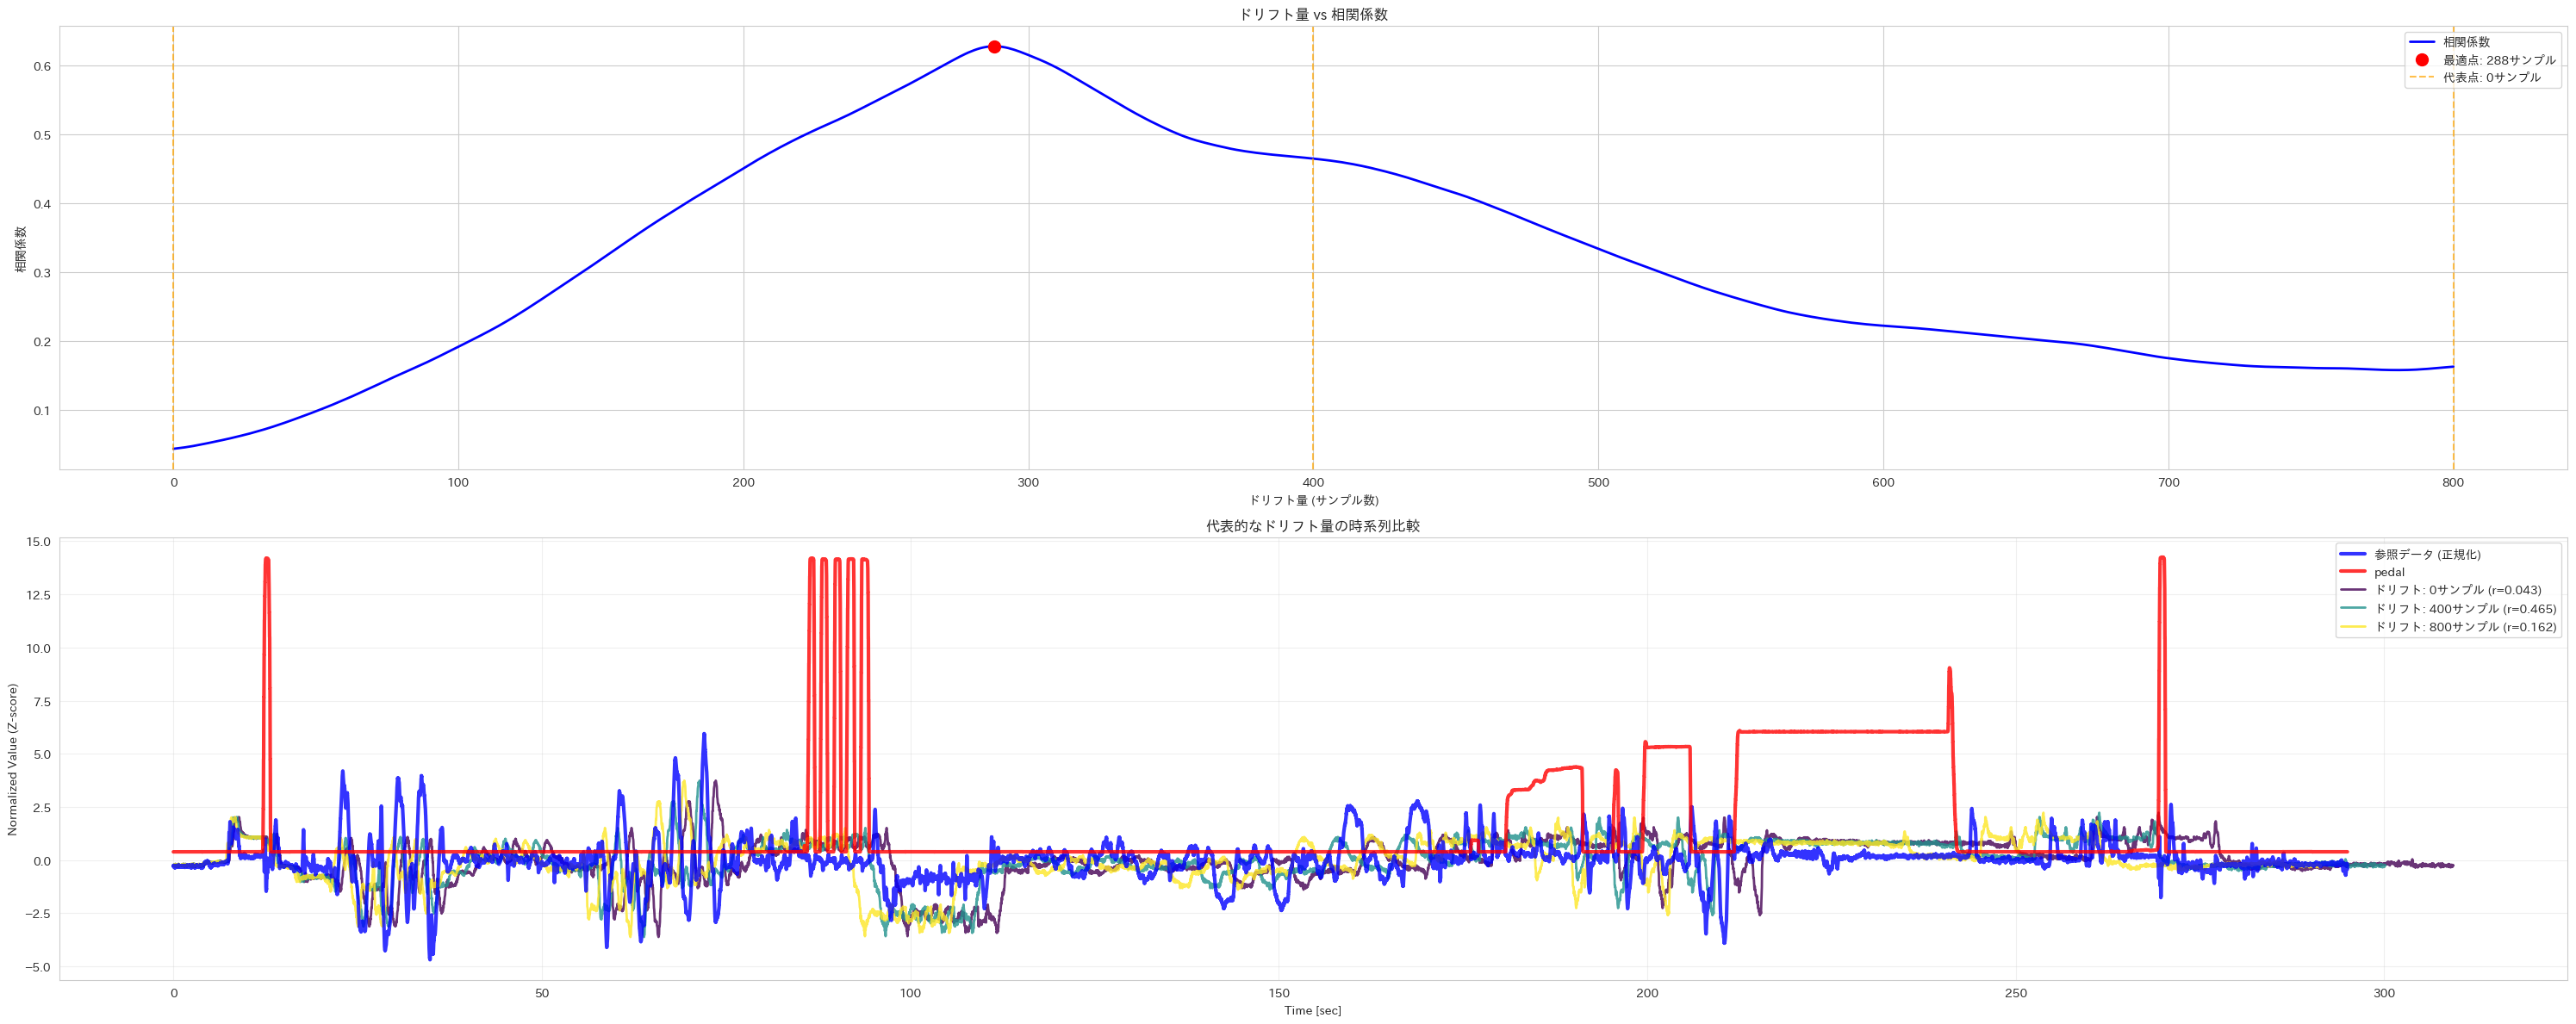


=== 探索結果サマリー ===
探索範囲: 0 ~ 800 サンプル
最適なドリフト量: 288 サンプル
最大相関係数: 0.6278

=== 代表サンプル詳細 ===
   ドリフト   0 サンプル: 相関係数 = 0.0432
   ドリフト 400 サンプル: 相関係数 = 0.4646
   ドリフト 800 サンプル: 相関係数 = 0.1625


In [6]:
def evaluate_linear_drifts_with_samples(df_ref, df_target, drift_range, 
                                       col_ref='COP_X', col_target='圧力中心列_2',
                                       num_sample_views=3):
    """
    線形ドリフトの評価＋代表的なサンプルを時系列グラフで表示
    """
    
    # --- 1. 前処理: 正規化 ---
    ref_data = df_ref[col_ref]
    ref_norm = (ref_data - ref_data.mean()) / ref_data.std()
    
    target_data = df_target[col_target]
    target_norm = (target_data - target_data.mean()) / target_data.std()
    
    # --- 2. 時間軸計算の準備 ---
    dt_mean = df_target['time'].diff().mean()
    t_start = df_target['time'].min()
    t_end_orig = df_target['time'].max()
    duration = t_end_orig - t_start # 全体長さ
    
    # --- 3. 全範囲で相関計算 ---
    all_results = []
    for drift_samples in range(drift_range[0], drift_range[1] + 1):
        total_lag_time = drift_samples * dt_mean
        scale_factor = duration / (duration + total_lag_time)
        new_time = t_start + (df_target['time'] - t_start) * scale_factor
        
        # 補間
        f_interp = interpolate.interp1d(new_time, target_norm, 
                                      bounds_error=False, fill_value='extrapolate')
        target_aligned = f_interp(df_ref['time'])
        
        # 相関計算
        valid_mask = ~np.isnan(target_aligned)
        if np.sum(valid_mask) > 10:
            correlation = np.corrcoef(ref_norm[valid_mask], target_aligned[valid_mask])[0,1]
        else:
            correlation = -1
            
        all_results.append((drift_samples, correlation))
    
    # 結果をソート
    all_results.sort(key=lambda x: x[0])
    drifts, corrs = zip(*all_results)
    
    # --- 4. 代表サンプルの選択 ---
    if len(drifts) <= num_sample_views:
        sample_drifts = drifts
    else:
        # 最小、中央、最大から選択
        indices = [
            0,  # 最小
            len(drifts) // 2,  # 中央
            len(drifts) - 1  # 最大
        ]
        sample_drifts = [drifts[i] for i in indices]
    
    # --- 5. 可視化 ---
    fig = plt.figure(figsize=(30, 12))
    
    # 5-1. 相関グラフ
    ax1 = plt.subplot(2, 1, 1)
    best_idx = np.argmax(corrs)
    plt.plot(drifts, corrs, 'b-', linewidth=2, label='相関係数')
    plt.plot(drifts[best_idx], corrs[best_idx], 'ro', markersize=10, 
             label=f'最適点: {drifts[best_idx]}サンプル')
    
    # 代表サンプルを縦線で表示
    for drift in sample_drifts:
        idx = drifts.index(drift)
        plt.axvline(x=drift, color='orange', linestyle='--', alpha=0.7,
                   label=f'代表点: {drift}サンプル' if drift == sample_drifts[0] else "")
    
    plt.xlabel('ドリフト量 (サンプル数)')
    plt.ylabel('相関係数')
    plt.title('ドリフト量 vs 相関係数')
    plt.grid(True)
    plt.legend()
    
    # 5-2. 時系列比較グラフ
    ax2 = plt.subplot(2, 1, 2)
    
    # 参照データ
    plt.plot(df_ref['time'], ref_norm, color='blue', linewidth=3, 
             alpha=0.8, label='参照データ (正規化)', zorder=10)
    plt.plot(df_ref['time'], df_ref['pedal'], color='red', linewidth=3, 
             alpha=0.8, label='pedal', zorder=10)
    
    # カラーマップ
    colors = plt.cm.viridis(np.linspace(0, 1, len(sample_drifts)))
    
    # 各代表サンプルの時系列をプロット
    for i, drift_samples in enumerate(sample_drifts):
        total_lag_time = drift_samples * dt_mean
        scale_factor = duration / (duration + total_lag_time)
        new_time = t_start + (df_target['time'] - t_start) * scale_factor
        
        # このドリフト量での相関係数を検索
        drift_corr = next((corr for drift, corr in all_results if drift == drift_samples), 0)
        
        plt.plot(new_time, target_norm, 
                 color=colors[i], linewidth=2, alpha=0.8,
                 label=f'ドリフト: {drift_samples}サンプル (r={drift_corr:.3f})')
    
    plt.title('代表的なドリフト量の時系列比較')
    plt.xlabel('Time [sec]')
    plt.ylabel('Normalized Value (Z-score)')
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    
    # 後半部分を拡大表示
    # plt.xlim(200, 300)
    # plt.ylim(-20, 20)
    
    plt.tight_layout()
    plt.show()
    
    # --- 6. 結果表示 ---
    print("\n=== 探索結果サマリー ===")
    print(f"探索範囲: {drift_range[0]} ~ {drift_range[1]} サンプル")
    print(f"最適なドリフト量: {drifts[best_idx]} サンプル")
    print(f"最大相関係数: {corrs[best_idx]:.4f}")
    
    print(f"\n=== 代表サンプル詳細 ===")
    for drift in sample_drifts:
        idx = drifts.index(drift)
        marker = "★" if drift == drifts[best_idx] else "  "
        print(f"{marker} ドリフト {drift:3d} サンプル: 相関係数 = {corrs[idx]:.4f}")
    
    return all_results, sample_drifts

# ==========================================
# 実行例
# ==========================================

# filter_processor = DataFrameLowpassFilter(
#     sampling_freq=100, 
#     cutoff_freq=5, 
#     order=1
# )

# # 複数列を一度にフィルタリング
# columns_to_process = ['FX', 'FY']
# df_filtered = filter_processor.filter_dataframe(df_cleaned, columns_to_process)



all_results, sample_drifts = evaluate_linear_drifts_with_samples(
    df_mock_tmp, #df_cleaned,
    df_seat, 
    drift_range=[0,800],  # 探索範囲
    # col_ref='FY_filtered',
    # col_target='荷重(N)_1',

    col_ref='COP_X', 
    col_target='圧力中心列_1',
    num_sample_views=3  # 表示する代表点の数
)

In [7]:
subject_id_

np.int64(7)

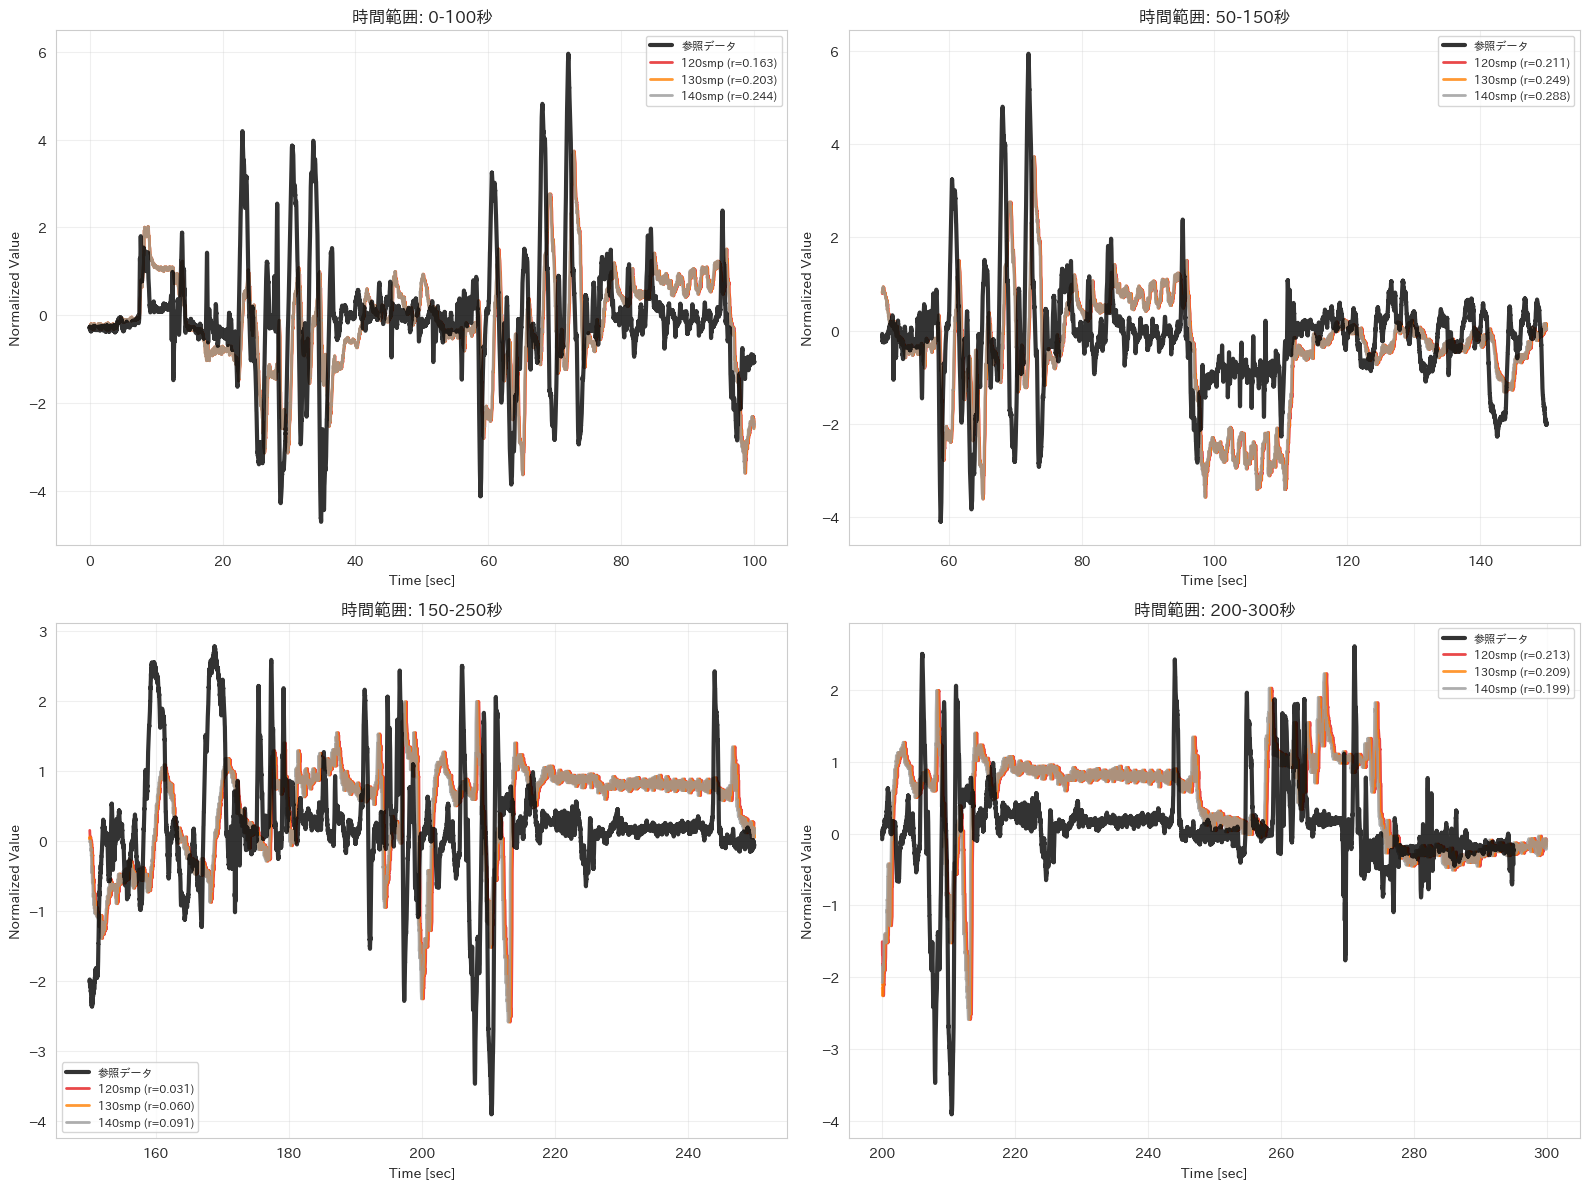


=== 指定ドリフト量の全体相関 ===
ドリフト 120 サンプル: 全体相関 = 0.2360
ドリフト 130 サンプル: 全体相関 = 0.2626
ドリフト 140 サンプル: 全体相関 = 0.2902


In [8]:
def compare_detailed_samples(df_ref, df_target, specific_drifts, 
                           col_ref='COP_X', col_target='圧力中心列_2',
                           focus_range=(200, 300)):
    """
    特定のドリフト量を詳細に比較（複数区間で表示）
    """
    
    # --- 前処理 ---
    ref_data = df_ref[col_ref]
    ref_norm = (ref_data - ref_data.mean()) / ref_data.std()
    
    target_data = df_target[col_target]
    target_norm = (target_data - target_data.mean()) / target_data.std()
    
    dt_mean = df_target['time'].diff().mean()
    t_start = df_target['time'].min()
    t_end_orig = df_target['time'].max()
    duration = t_end_orig - t_start
    
    # --- 複数サブプロットで表示 ---
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    # カラーマップ
    colors = plt.cm.Set1(np.linspace(0, 1, len(specific_drifts)))
    
    # 各注目区間をプロット
    focus_ranges = [
        (0, 100),     # 最初の部分
        (50, 150),   # 前半部分
        (150, 250),  # 中間部分
        (200, 300),  # 後半部分
    ]
    
    for ax_idx, (start_time, end_time) in enumerate(focus_ranges):
        if ax_idx >= len(axes):
            break
            
        ax = axes[ax_idx]
        
        # 参照データ
        mask_ref = (df_ref['time'] >= start_time) & (df_ref['time'] <= end_time)
        ax.plot(df_ref['time'][mask_ref], ref_norm[mask_ref], 
                color='black', linewidth=3, alpha=0.8, 
                label='参照データ', zorder=10)
        
        # 各ドリフト量
        for i, drift_samples in enumerate(specific_drifts):
            total_lag_time = drift_samples * dt_mean
            scale_factor = duration / (duration + total_lag_time)
            new_time = t_start + (df_target['time'] - t_start) * scale_factor
            
            # 相関係数計算（この区間のみ）
            mask_target = (new_time >= start_time) & (new_time <= end_time)
            if np.sum(mask_target) > 5:
                # この区間内での相関を計算
                time_in_range = new_time[mask_target]
                values_in_range = target_norm[mask_target]
                
                # 参照データと同じ時間点に補間
                from scipy import interpolate
                f_interp = interpolate.interp1d(time_in_range, values_in_range, 
                                              bounds_error=False, fill_value='extrapolate')
                target_aligned = f_interp(df_ref['time'][mask_ref])
                
                # 相関計算
                valid_mask = ~np.isnan(target_aligned)
                if np.sum(valid_mask) > 5:
                    correlation = np.corrcoef(ref_norm[mask_ref][valid_mask], 
                                            target_aligned[valid_mask])[0,1]
                else:
                    correlation = 0
            else:
                correlation = 0
            
            # プロット
            ax.plot(new_time[mask_target], target_norm[mask_target],
                   color=colors[i], linewidth=2, alpha=0.8,
                   label=f'{drift_samples}smp (r={correlation:.3f})')
        
        ax.set_title(f'時間範囲: {start_time}-{end_time}秒')
        ax.set_xlabel('Time [sec]')
        ax.set_ylabel('Normalized Value')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # 各ドリフト量の全体相関も表示
    print("\n=== 指定ドリフト量の全体相関 ===")
    for drift_samples in specific_drifts:
        total_lag_time = drift_samples * dt_mean
        scale_factor = duration / (duration + total_lag_time)
        new_time = t_start + (df_target['time'] - t_start) * scale_factor
        
        # 補間
        from scipy import interpolate
        f_interp = interpolate.interp1d(new_time, target_norm, 
                                      bounds_error=False, fill_value='extrapolate')
        target_aligned = f_interp(df_ref['time'])
        
        # 全体相関
        valid_mask = ~np.isnan(target_aligned)
        if np.sum(valid_mask) > 10:
            overall_correlation = np.corrcoef(ref_norm[valid_mask], target_aligned[valid_mask])[0,1]
            print(f"ドリフト {drift_samples:3d} サンプル: 全体相関 = {overall_correlation:.4f}")

# 特定のドリフト量を詳細比較
compare_detailed_samples(
    df_mock_tmp, 
    df_seat, 
    specific_drifts=[120, 130, 140],  # 比較したい特定の値
    col_ref='COP_X', 
    col_target='圧力中心列_1'
)

補正情報:
  - ズレサンプル数: 288
  - ズレ時間換算  : 6.8577 sec
  - 適用スケール  : 0.97831489


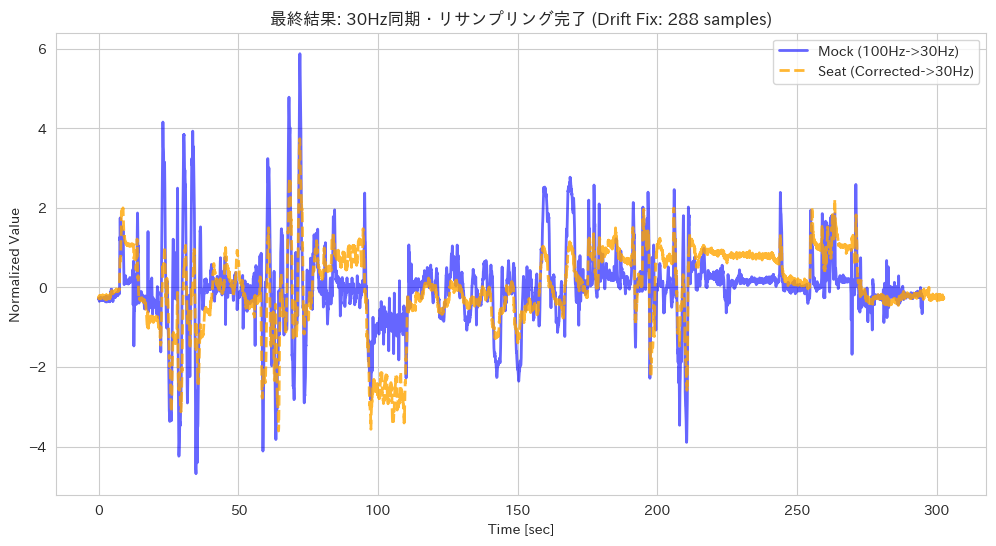

--- df_mock_30hz ---
       time     COP_X     COP_Y      steer       trg     pedal
0  0.000000  0.019502 -0.109412  21.172789  5.055838  0.386862
1  0.033333  0.019313 -0.109023  21.172789  5.055999  0.388165
2  0.066667  0.019214 -0.108542  21.172865  5.056208  0.386862
3  0.100000  0.019570 -0.108526  21.171961 -0.000014  0.389469
4  0.133333  0.018974 -0.108231  21.171445 -0.000009  0.387948

--- df_seat_30hz ---
       time  平均圧力_2  最低圧力_2  ピーク圧力_2  接触域 (cm²)_2  選択領域(cm²)_2     接触 %_2  \
0  0.000000    0.89    0.13     3.41   904.840000      2090.32  43.290000   
1  0.033333    0.89    0.13     3.41   908.583098      2090.32  43.469901   
2  0.066667    0.89    0.13     3.41   902.011028      2090.32  43.149865   
3  0.100000    0.89    0.13     3.41   898.544657      2090.32  42.987834   
4  0.133333    0.89    0.13     3.41   896.319788      2090.32  42.877629   

      荷重(N)_2    標準偏差_2  平均_2  ...    最低圧力_1   ピーク圧力_1  接触域 (cm²)_1  \
0  806.790000  0.770000   0.8  ...  0.130000 

In [9]:


# =========================================================
# 1. パラメータ設定
# =========================================================
BEST_DRIFT_SAMPLES = 288 # 見つけたベストな値
TARGET_FS = 30.0           # 目標サンプリング周波数 (Hz)

# =========================================================
# 2. df_seat の時間軸を補正（永続化）
# =========================================================
def apply_drift_correction(df, drift_samples):
    """
    見つけたドリフト量(samples)に基づいて時間軸を実際に書き換える
    """
    df_fixed = df.copy()
    
    # 統計量の計算
    dt_mean = df_fixed['time'].diff().mean()
    t_start = df_fixed['time'].min()
    t_end   = df_fixed['time'].max()
    duration = t_end - t_start
    
    # ズレ時間の計算 (35サンプル * 1サンプルの時間)
    total_lag_time = drift_samples * dt_mean
    
    # 伸縮率 (Scale Factor) の計算
    # visualize関数と同じ計算式を使用
    scale_factor = duration / (duration + total_lag_time)
    
    print(f"補正情報:")
    print(f"  - ズレサンプル数: {drift_samples}")
    print(f"  - ズレ時間換算  : {total_lag_time:.4f} sec")
    print(f"  - 適用スケール  : {scale_factor:.8f}")
    
    # 時間軸の更新
    df_fixed['time'] = t_start + (df_fixed['time'] - t_start) * scale_factor
    
    return df_fixed

# df_seat の時間を修正
df_seat_fixed = apply_drift_correction(df_seat, BEST_DRIFT_SAMPLES)


# =========================================================
# 3. 共通の30Hzへのリサンプリング
# =========================================================
def resample_to_target_hz(df, time_col, data_cols, target_fs):
    """
    指定されたDataFrameをtarget_fs(Hz)にリサンプリングする関数
    """
    # 元データ
    t_src = df[time_col].values
    # 時間軸の開始と終了（データの範囲内）
    t_min, t_max = t_src.min(), t_src.max()
    
    # 新しい時間軸 (startからendまで 1/fs 刻み)
    new_time = np.arange(t_min, t_max, 1.0 / target_fs)
    
    # 結果格納用DataFrame
    df_resampled = pd.DataFrame({time_col: new_time})
    
    # 指定されたデータ列を補間
    for col in data_cols:
        # 線形補間 (linear) または 3次スプライン (cubic)
        f = interpolate.interp1d(t_src, df[col].values, kind='linear', fill_value="extrapolate")
        df_resampled[col] = f(new_time)
        
    return df_resampled

# --- リサンプリング実行 ---

mock_cols = ['COP_X', 'COP_Y', 'steer', 'trg', 'pedal']
seat_cols = ['平均圧力_1', '最低圧力_1',
       'ピーク圧力_1', '接触域 (cm²)_1', '選択領域(cm²)_1', '接触 %_1', '荷重(N)_1', '標準偏差_1',
       '平均_1', '圧力中心行_1', '圧力中心列_1', '平均圧力_2', '最低圧力_2', 'ピーク圧力_2',
       '接触域 (cm²)_2', '選択領域(cm²)_2', '接触 %_2', '荷重(N)_2', '標準偏差_2', '平均_2',
       '圧力中心行_2', '圧力中心列_2']

# df_mock_tmp (元100Hz) -> 30Hz
df_mock_30hz = resample_to_target_hz(
    df_mock_tmp, 
    time_col='time', 
    data_cols=mock_cols, # 必要な列を指定
    target_fs=TARGET_FS
)

# df_seat_fixed (補正済み40Hz) -> 30Hz
df_seat_30hz = resample_to_target_hz(
    df_seat_fixed, 
    time_col='time', 
    data_cols=seat_cols, # 必要な列を指定
    target_fs=TARGET_FS
)



# Step1: _1 → _tmp
df_seat_30hz.columns = df_seat_30hz.columns.str.replace(r"_1$", "_tmp", regex=True)
# Step2: _2 → _1
df_seat_30hz.columns = df_seat_30hz.columns.str.replace(r"_2$", "_1", regex=True)
# Step3: _tmp → _2
df_seat_30hz.columns = df_seat_30hz.columns.str.replace(r"_tmp$", "_2", regex=True)



# =========================================================
# 4. 結果の確認（結合・プロット）
# =========================================================

# 時間軸を完全に合わせるため、共通の時間範囲でデータを結合（Merge）しても良いですが、
# ここではプロットで確認します。

# 正規化関数（比較用）
def z_score(series):
    return (series - series.mean()) / series.std()

plt.figure(figsize=(12, 6))

# 青: df_mock (30Hz)
plt.plot(df_mock_30hz['time'], z_score(df_mock_30hz['COP_X']), 
         label='Mock (100Hz->30Hz)', color='blue', alpha=0.6, linewidth=2)

# オレンジ: df_seat (補正済み->30Hz)
plt.plot(df_seat_30hz['time'], z_score(df_seat_30hz['圧力中心列_2']), 
         label='Seat (Corrected->30Hz)', color='orange', alpha=0.8, linestyle='--', linewidth=2)

plt.title(f"最終結果: 30Hz同期・リサンプリング完了 (Drift Fix: {BEST_DRIFT_SAMPLES} samples)")
plt.xlabel("Time [sec]")
plt.ylabel("Normalized Value")
plt.legend()
plt.grid(True)

# ズレやすい後半を拡大
t_end = df_mock_30hz['time'].max()
# plt.xlim(t_end - 10, t_end) 

plt.show()

# データフレームの中身確認
print("--- df_mock_30hz ---")
print(df_mock_30hz.head())
print("\n--- df_seat_30hz ---")
print(df_seat_30hz.head())

In [10]:
df_all = pd.merge(df_mock_30hz, df_seat_30hz, on='time', how='left', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)') 

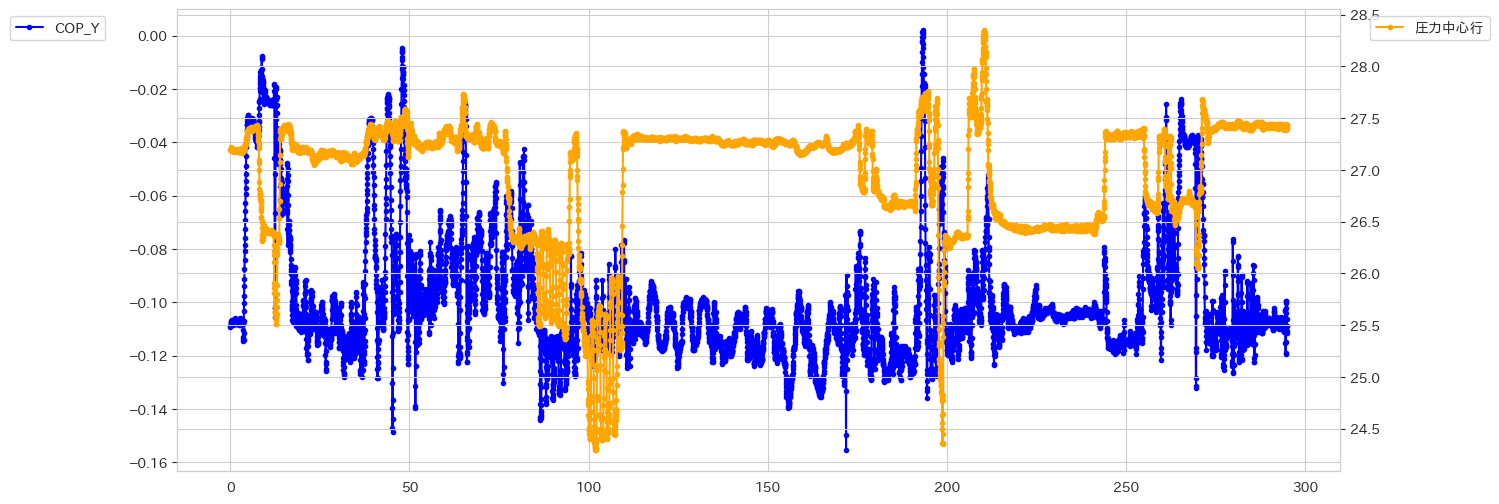

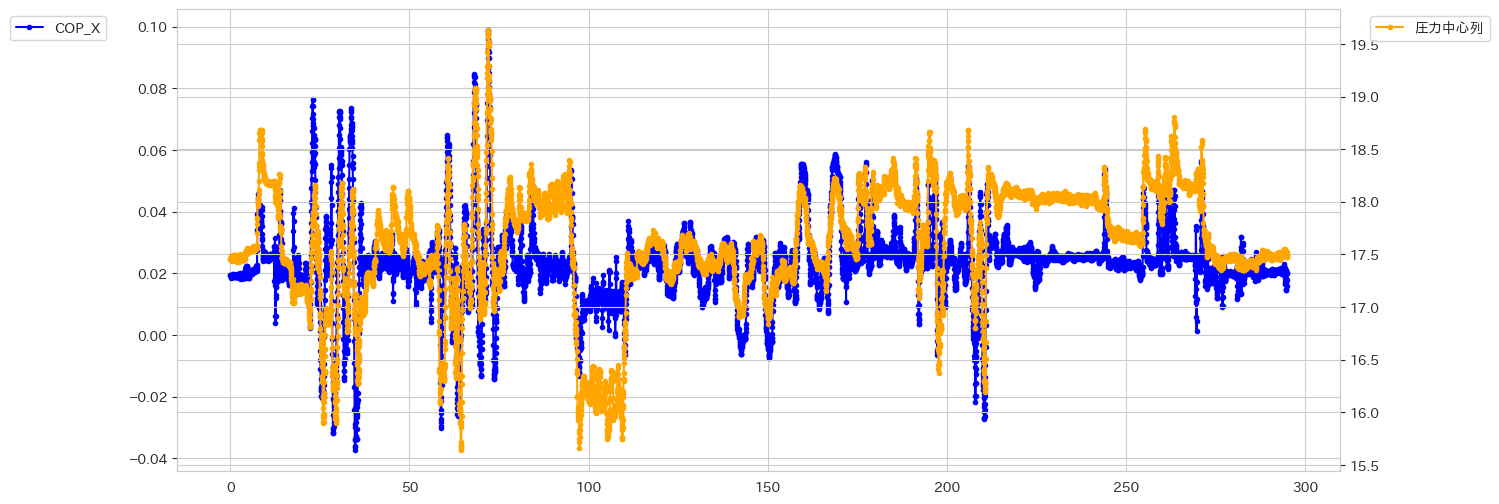

In [11]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(1, 1, 1)
ax2 = ax1.twinx() 
ax1.plot(df_all.time,df_all['COP_Y'],'.-',color='blue',label='COP_Y')
ax2.plot(df_all['time'],df_all['圧力中心行_2'],'.-',color='orange',label='圧力中心行') 
ax1.legend(bbox_to_anchor=(-0.15, 1.0), loc='upper left')
ax2.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')
plt.show()

fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(1, 1, 1)
ax2 = ax1.twinx() 
ax1.plot(df_all["time"],df_all['COP_X'],'.-',color='blue',label='COP_X')
ax2.plot(df_all['time'],df_all['圧力中心列_2'],'.-',color='orange',label='圧力中心列') # Y
ax1.legend(bbox_to_anchor=(-0.15, 1.0), loc='upper left')
ax2.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')
plt.show()

In [12]:
import pickle
df_all['subject_id'] = subject_id_
with open(f'2F_{subject_id_}.pkl','wb') as f:
    pickle.dump(df_all,f)

# ここから

In [2]:

import pickle

dfs = []

for ch in ['2F_1','2F_2', '2F_4', '2F_5','2F_6','2F_7']:
    fname = f"{ch}.pkl"
    with open(fname, "rb") as f:
        df = pickle.load(f)
        dfs.append(df)

# 縦に連結
df_all = pd.concat(dfs, axis=0, ignore_index=True)

In [5]:
df_all.columns

Index(['time', 'COP_X', 'COP_Y', 'steer', 'trg', 'pedal', '平均圧力_1', '最低圧力_1',
       'ピーク圧力_1', '接触域 (cm²)_1', '選択領域(cm²)_1', '接触 %_1', '荷重(N)_1', '標準偏差_1',
       '平均_1', '圧力中心行_1', '圧力中心列_1', '平均圧力_2', '最低圧力_2', 'ピーク圧力_2',
       '接触域 (cm²)_2', '選択領域(cm²)_2', '接触 %_2', '荷重(N)_2', '標準偏差_2', '平均_2',
       '圧力中心行_2', '圧力中心列_2', 'subject_id'],
      dtype='object')

# 実装コード: 初期値基準（Relative）学習


🚀 Model B (Ridge) Training & LabVIEW Export Pipeline
Pre-processing: Subtracting initial bias (Relative Change)...
Test Subject ID: 7

--- Training Loop ---


C:\Users\m221177\AppData\Local\Temp\ipykernel_7396\2249326599.py:76: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  relative_df = temp_df.groupby('subject_id', group_keys=False).apply(subtract_initial_bias)


Target: COP_X  | Best Alpha: 500.0 | Test R2: 0.5987
Target: COP_Y  | Best Alpha: 500.0 | Test R2: 0.7771

✅ Python Model saved: 'model_b_trained.pkl'

--- LabVIEW Parameters Export ---
[COP_X] Coefs calculated.
[COP_Y] Coefs calculated.
Weights Shape: (9, 2)

--- Generating Verification Data for LabVIEW ---
Test Input (First row of X_test):
 [ 1.35506667e-04 -1.30768000e-03 -1.78992467e-01 -2.71126748e+00
  3.16619112e-03  6.40750982e-02  2.05231224e-02  5.90071957e+00
 -7.43931819e-03]
------------------------------
Prediction Check:
 Target | Python Pipe | LabVIEW Calc | Match?
 COP_X  |     0.00748 |      0.00748 | ✅
 COP_Y  |     0.01531 |      0.01531 | ✅

[保存完了] 以下のファイルをLabVIEWプロジェクトにコピーしてください:
 1. model_b_weights.csv               : 重み行列 (入力数 x 2)
 2. model_b_biases.csv                : バイアス (1 x 2)
 3. model_b_test_input.csv            : 【検証用】入力データ (LabVIEWで読込 -> 行列積に入力)
 4. model_b_test_output_expected.csv  : 【検証用】期待される正解値


c:\Users\m221177\Miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\m221177\Miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


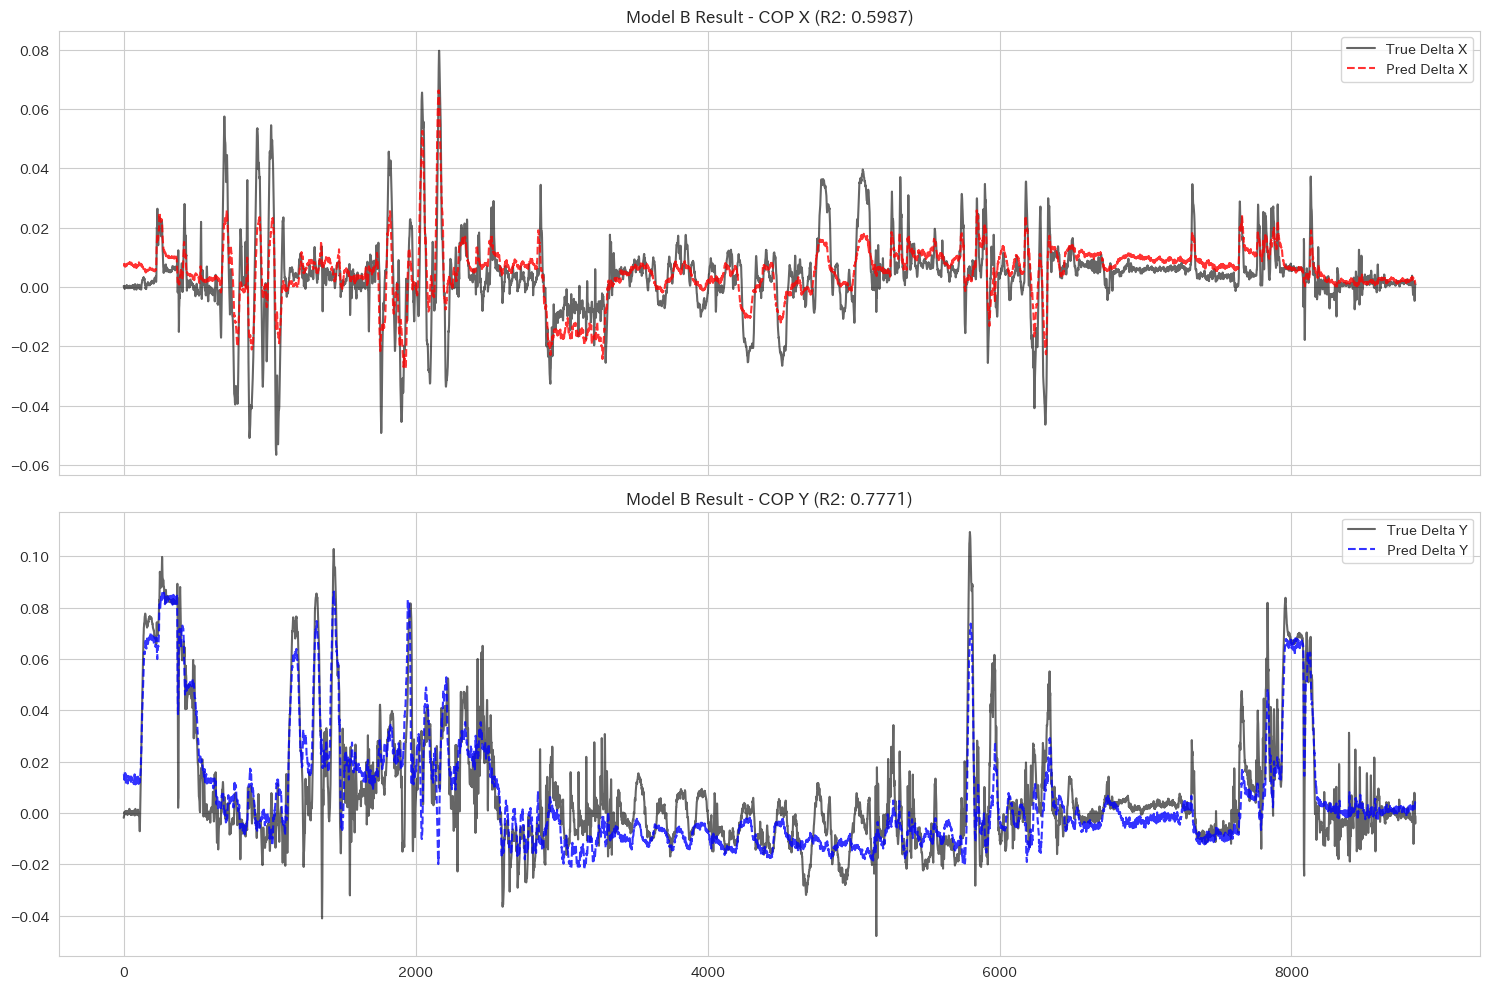

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut

# =========================================================
# 0. 前提: df_all の読み込みチェック
# =========================================================
if 'df_all' not in locals():
    print("Warning: 'df_all' is not defined. Please load your dataset into 'df_all' before running.")
    # テスト実行用にダミーデータを作る場合のガード（実際は無視してください）
    # df_all = pd.DataFrame(...) 
    pass

# =========================================================
# 1. データ準備 & 前処理
# =========================================================

# 理想
# features = [ 
#     '荷重(N)_1', 
#     '圧力中心行_1', '圧力中心列_1', 
#     '圧力中心行_2', 
#     'pedal','steer'
# ]

# モデルAで作りやすい(第一候補群)
features = [ 
    'steer', 'pedal', 
    '接触 %_1', '荷重(N)_1',
    '圧力中心行_1', '圧力中心列_1', 
    '平均圧力_2',
    '荷重(N)_2', '圧力中心列_2', 
]
# モデルAで精度落ちる(第二候補群)
# features = [ 
#     'steer', 'pedal', 
#     '接触 %_1', '荷重(N)_1',
#     '平均圧力_2','標準偏差_1',
#     '圧力中心行_1', '圧力中心列_1', 
#     '荷重(N)_2', '圧力中心列_2', 
# ]

target_cols = ['COP_X', 'COP_Y']
cols_to_keep = features + target_cols + ['subject_id']

# df_allが存在する場合のみ実行
if 'df_all' in locals():
    print("\n" + "="*60)
    print("🚀 Model B (Ridge) Training & LabVIEW Export Pipeline")
    print("="*60)

    # NaN削除
    temp_df = df_all[cols_to_keep].dropna()

    # --- 初期値基準（Displacement）への変換 ---
    # LabVIEW側でも同様の「初期値引き」処理が必要になります
    CALIB_SAMPLES = 50 

    def subtract_initial_bias(group):
        initial_X = group[features].iloc[:CALIB_SAMPLES].mean()
        initial_Y = group[target_cols].iloc[:CALIB_SAMPLES].mean()
        
        group_rel = group.copy()
        group_rel[features] = group[features] - initial_X
        group_rel[target_cols] = group[target_cols] - initial_Y
        return group_rel

    print("Pre-processing: Subtracting initial bias (Relative Change)...")
    relative_df = temp_df.groupby('subject_id', group_keys=False).apply(subtract_initial_bias)

    # =========================================================
    # 2. 学習設定
    # =========================================================
    TEST_SUBJECT_ID = 7 
    df_test = relative_df[relative_df['subject_id'] == TEST_SUBJECT_ID]
    df_train_val = relative_df[relative_df['subject_id'] != TEST_SUBJECT_ID]

    X_train_val = df_train_val[features]
    groups_train_val = df_train_val['subject_id']
    X_test = df_test[features]

    print(f"Test Subject ID: {TEST_SUBJECT_ID}")
    
    trained_models_b = {}
    results = {}

    # =========================================================
    # 3. 学習ループ
    # =========================================================
    print("\n--- Training Loop ---")
    for target in target_cols:
        y_train_val_single = df_train_val[target]
        y_test_single = df_test[target]

        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('ridge', Ridge())
        ])
        
        param_grid = {'ridge__alpha': [0.01, 0.1, 1.0, 10.0, 100.0, 500.0]}
        
        logo = LeaveOneGroupOut()
        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grid,
            cv=logo,
            scoring='r2',
            n_jobs=-1
        )
        
        grid_search.fit(X_train_val, y_train_val_single, groups=groups_train_val)
        
        best_model = grid_search.best_estimator_
        best_alpha = grid_search.best_params_['ridge__alpha']
        trained_models_b[target] = best_model
        
        # 評価
        y_pred_rel = best_model.predict(X_test)
        r2 = r2_score(y_test_single, y_pred_rel)
        
        results[target] = {'r2': r2, 'y_true': y_test_single, 'y_pred': y_pred_rel}
        print(f"Target: {target:<6} | Best Alpha: {best_alpha:<5} | Test R2: {r2:.4f}")

    # =========================================================
    # 4. モデル保存
    # =========================================================
    artifacts_b = {
        'models': trained_models_b,
        'features': features,
        'targets': target_cols,
        'calib_samples': CALIB_SAMPLES
    }
    joblib.dump(artifacts_b, 'model_b_trained.pkl')
    print(f"\n✅ Python Model saved: 'model_b_trained.pkl'")

    # =========================================================
    # 5. LabVIEW用 係数変換 & 出力
    # =========================================================
    print("\n--- LabVIEW Parameters Export ---")

    weights_list = [] 
    biases_list = []  

    for target in target_cols:
        model_pipeline = trained_models_b[target]
        
        # A. パラメータ取得
        scaler = model_pipeline.named_steps['scaler']
        ridge = model_pipeline.named_steps['ridge']
        
        mu = scaler.mean_
        sigma = scaler.scale_
        w_ridge = ridge.coef_
        b_ridge = ridge.intercept_
        
        # B. 係数合成 (Affine Transformation)
        # Python: y = ((x - mu)/sigma) * w + b
        # LabVIEW: y = x * (w/sigma) + (b - w*mu/sigma)
        
        w_effective = w_ridge / sigma
        bias_correction = np.dot(w_effective, mu)
        b_effective = b_ridge - bias_correction
        
        weights_list.append(w_effective)
        biases_list.append(b_effective)
        
        print(f"[{target}] Coefs calculated.")

    # C. 整形
    # Weights: (特徴量数 x ターゲット数) -> LabVIEW行列積 [A x B] 用
    labview_weights = np.array(weights_list).T 
    # Bias: (1 x ターゲット数) -> LabVIEW加算 [Add] 用
    labview_biases = np.array(biases_list).reshape(1, -1)

    print(f"Weights Shape: {labview_weights.shape}")

    # D. CSV保存 (UTF-8 BOM付き)
    # ヘッダーなし、インデックスなしがLabVIEWでは一番読みやすい
    pd.DataFrame(labview_weights).to_csv("model_b_weights.csv", header=False, index=False, encoding='utf-8')
    pd.DataFrame(labview_biases).to_csv("model_b_biases.csv", header=False, index=False, encoding='utf-8')

    # =========================================================
    # 6. 検証 & テストデータ出力 (Verification Data)
    # =========================================================
    print("\n--- Generating Verification Data for LabVIEW ---")
    
    # 6-1. テスト入力データの作成 (X_testの最初の1行を使用)
    # LabVIEWに入力するための「検証用入力CSV」
    test_input_row = X_test.iloc[0].values.reshape(1, -1)
    
    pd.DataFrame(test_input_row).to_csv("model_b_test_input.csv", header=False, index=False, encoding='utf-8')
    
    # 6-2. 期待される出力値の計算 (Pythonモデル vs 合成係数)
    pred_python_x = trained_models_b['COP_X'].predict(test_input_row)[0]
    pred_python_y = trained_models_b['COP_Y'].predict(test_input_row)[0]
    
    # 合成係数での計算 (LabVIEWシミュレーション)
    pred_manual = np.dot(test_input_row, labview_weights) + labview_biases
    pred_manual_x = pred_manual[0][0]
    pred_manual_y = pred_manual[0][1]
    
    # 期待値CSVの保存
    pd.DataFrame(pred_manual).to_csv("model_b_test_output_expected.csv", header=False, index=False, encoding='utf-8')

    print(f"Test Input (First row of X_test):")
    print(f" {test_input_row.flatten()}")
    print("-" * 30)
    print(f"Prediction Check:")
    print(f" Target | Python Pipe | LabVIEW Calc | Match?")
    print(f" COP_X  | {pred_python_x:11.5f} | {pred_manual_x:12.5f} | {'✅' if np.isclose(pred_python_x, pred_manual_x) else '❌'}")
    print(f" COP_Y  | {pred_python_y:11.5f} | {pred_manual_y:12.5f} | {'✅' if np.isclose(pred_python_y, pred_manual_y) else '❌'}")

    print("\n[保存完了] 以下のファイルをLabVIEWプロジェクトにコピーしてください:")
    print(" 1. model_b_weights.csv               : 重み行列 (入力数 x 2)")
    print(" 2. model_b_biases.csv                : バイアス (1 x 2)")
    print(" 3. model_b_test_input.csv            : 【検証用】入力データ (LabVIEWで読込 -> 行列積に入力)")
    print(" 4. model_b_test_output_expected.csv  : 【検証用】期待される正解値")
    
    # =========================================================
    # 5. 可視化 (確認用)
    # =========================================================
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
    # COP X
    res_x = results['COP_X']
    ax1.plot(res_x['y_true'].values, label='True Delta X', color='black', alpha=0.6)
    ax1.plot(res_x['y_pred'], label='Pred Delta X', color='red', linestyle='--', alpha=0.8)
    ax1.set_title(f"Model B Result - COP X (R2: {res_x['r2']:.4f})")
    ax1.legend(); ax1.grid(True)
    # COP Y
    res_y = results['COP_Y']
    ax2.plot(res_y['y_true'].values, label='True Delta Y', color='black', alpha=0.6)
    ax2.plot(res_y['y_pred'], label='Pred Delta Y', color='blue', linestyle='--', alpha=0.8)
    ax2.set_title(f"Model B Result - COP Y (R2: {res_y['r2']:.4f})")
    ax2.legend(); ax2.grid(True)
    plt.tight_layout()
    plt.show()

else:
    print("Error: df_all not found.")